In [1]:
import os
os.makedirs("src", exist_ok=True)
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
print("✅ Folders created: src/, data/, models/, outputs/")

✅ Folders created: src/, data/, models/, outputs/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import pandas as pd
import os

if os.path.exists("data/train(1).xlsx"):
    print("✅ TRAIN FILE FOUND!")
    try:
        df = pd.read_excel("data/train(1).xlsx")
        print(f"   - Successfully read {len(df)} rows.")
    except Exception as e:
        print(f"   - ❌ Error reading file: {e}")
else:
    print("❌ TRAIN FILE MISSING. Please drag 'train(1).xlsx' into the 'data' folder.")

✅ TRAIN FILE FOUND!
   - Successfully read 16209 rows.


In [5]:
!python train.py

Traceback (most recent call last):
  File "/content/train.py", line 178, in <module>
    main()
  File "/content/train.py", line 89, in main
    print("Device from config:", cfg.device)
                                 ^^^^^^^^^^
AttributeError: type object 'Config' has no attribute 'device'


In [6]:
%%writefile src/config.py
import os
from dataclasses import dataclass, field
import torch

def get_device():
    if torch.cuda.is_available():
        return "cuda"
    return "cpu"

@dataclass
class Config:

    train_xlsx: str = "data/train(1).xlsx"
    test_xlsx: str = "data/test2.xlsx"
    image_dir: str = "data/satellite"
    output_dir: str = "outputs"
    model_dir: str = "models"


    zoom: int = 18
    tile_size: int = 256


    img_size: int = 224
    batch_size: int = 32
    num_workers: int = 2
    lr: float = 1e-3
    weight_decay: float = 1e-4
    epochs: int = 4
    seed: int = 42
    val_split: float = 0.15
    grad_cam_samples: int = 6
    device: str = field(default_factory=get_device)

    tab_feats = [
        "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
        "waterfront", "view", "condition", "grade", "sqft_above",
        "sqft_basement", "yr_built", "yr_renovated", "zipcode",
        "sqft_living15", "sqft_lot15", "lat", "long"
    ]
    target: str = "price"

cfg = Config()

Overwriting src/config.py


In [7]:
!python train.py

Device from config: cuda
Torch CUDA available: True
GPU name: Tesla T4

Download Summary:
 - Already cached (skipped): 177
 - Newly downloaded: 21436
- Recovered on retry: 0
 - Failed: 0
 - Total images: 21613
 - Saved to: data/satellite
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Traceback (most recent call last):
  File "/content/train.py", line 178, in <module>
    main()
  File "/content/train.py", line 124, in main
    model = FusionModel(tab_dim=len(cfg.tab_feats)

In [8]:
%%writefile train.py
import os, math, argparse
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from src.config import cfg
from src.data_fetcher import download
from src.datasets import HouseDataset
from src.model import FusionModel
from src.gradcam import GradCAM
import matplotlib.pyplot as plt

def rmse(pred, true):
    return math.sqrt(mean_squared_error(true, pred))

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0

    for img, tab, y in loader:
        img = img.to(cfg.device)
        tab = tab.to(cfg.device)
        y = y.to(cfg.device)

        optimizer.zero_grad()
        pred = model(img, tab)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total += loss.item() * len(y)

    return total / len(loader.dataset)

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    ys, ps = [], []
    total = 0
    for img, tab, y in loader:
        img = img.to(cfg.device)
        tab = tab.to(cfg.device)
        y = y.to(cfg.device)
        pred = model(img, tab)
        loss = criterion(pred, y)
        total += loss.item() * len(y)
        ys.append(y.cpu().numpy()); ps.append(pred.cpu().numpy())

    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return total / len(loader.dataset), rmse(ps, ys), r2_score(ys, ps)

def run_gradcam(model, val_ds):
    gc = GradCAM(model)
    os.makedirs(os.path.join(cfg.output_dir, "gradcam"), exist_ok=True)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(min(cfg.grad_cam_samples, len(val_ds))):
        img, tab, y = val_ds[i]
        cam = gc(img, tab)

        orig = img.permute(1, 2, 0).numpy()
        orig = (orig * std + mean) * 255
        orig = np.clip(orig, 0, 255).astype(np.uint8)

        cam_resized = cv2.resize(
            cam,
            (orig.shape[1], orig.shape[0]),
            interpolation=cv2.INTER_LINEAR
        )

        heatmap = np.uint8(cam_resized * 255)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

        overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)
        overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)

        cv2.imwrite(os.path.join(cfg.output_dir, "gradcam", f"sample_{i}_gt_{y:.0f}.png"), overlay_bgr)

def main():
    print("Device from config:", cfg.device)
    print("Torch CUDA available:", torch.cuda.is_available())

    if torch.cuda.is_available():
        print("GPU name:", torch.cuda.get_device_name(0))

    os.makedirs(cfg.output_dir, exist_ok=True)
    os.makedirs(cfg.model_dir, exist_ok=True)


    train_df = pd.read_excel(cfg.train_xlsx)
    test_df = pd.read_excel(cfg.test_xlsx)


    img_paths = download(pd.concat([train_df, test_df], axis=0))


    train_df = train_df[train_df["id"].isin(img_paths.keys())]
    test_df = test_df[test_df["id"].isin(img_paths.keys())]


    scaler = StandardScaler()
    scaler.fit(train_df[cfg.tab_feats].astype(float))

    tr_df, val_df = train_test_split(train_df,test_size=cfg.val_split,random_state=cfg.seed)

    tr_ds = HouseDataset(tr_df, img_paths, scaler, train=True)
    val_ds = HouseDataset(val_df, img_paths, scaler, train=True)
    te_ds = HouseDataset(test_df, img_paths, scaler, train=False)

    tr_loader = DataLoader(tr_ds,batch_size=cfg.batch_size,shuffle=True,num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,num_workers=cfg.num_workers)
    te_loader = DataLoader(te_ds,batch_size=cfg.batch_size,shuffle=False,num_workers=cfg.num_workers)

    model = FusionModel(tab_in=len(cfg.tab_feats)).to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(),lr=cfg.lr,weight_decay=cfg.weight_decay)
    criterion = nn.MSELoss()

    best_rmse = float("inf")

    print(f"Starting training for {cfg.epochs} epochs...")

    for epoch in range(cfg.epochs):
        tr_loss = train_one_epoch(model, tr_loader, optimizer, criterion)
        val_loss, val_rmse, val_r2 = eval_model(model, val_loader, criterion)

        print(
            f"Epoch [{epoch+1}/{cfg.epochs}] | "
            f"tr_loss {tr_loss:.4f} | "
            f"val_loss {val_loss:.4f} | "
            f"rmse {val_rmse:.4f} | "
            f"r2 {val_r2:.4f}"
        )

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save({
                    "model": model.state_dict(),
                    "scaler_mean": scaler.mean_,
                    "scaler_scale": scaler.scale_
                },
                os.path.join(cfg.model_dir, "best_model.pt")
            )


    ckpt = torch.load(os.path.join(cfg.model_dir, "best_model.pt"),map_location=cfg.device)
    model.load_state_dict(ckpt["model"])


    preds, ids = [], []
    model.eval()

    with torch.no_grad():
        for img, tab, pid in te_loader:
            img = img.to(cfg.device)
            tab = tab.to(cfg.device)

            pred = model(img, tab).cpu().numpy()
            preds.extend(pred.tolist())
            ids.extend(pid.tolist())
    sub = pd.DataFrame({"id": ids,"predicted_price": preds})
    sub.to_csv(os.path.join(cfg.output_dir, "submission.csv"),index=False)
    print("Saved outputs/submission.csv")

    run_gradcam(model, val_ds)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.parse_args()
    main()

Overwriting train.py


In [9]:
!python train.py

Device from config: cuda
Torch CUDA available: True
GPU name: Tesla T4

Download Summary:
 - Already cached (skipped): 21613
 - Newly downloaded: 0
- Recovered on retry: 0
 - Failed: 0
 - Total images: 21613
 - Saved to: data/satellite
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 163MB/s]
Starting training for

In [10]:
%%writefile train.py
import os, math, argparse
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from src.config import cfg
from src.data_fetcher import download
from src.datasets import HouseDataset
from src.model import FusionModel
from src.gradcam import GradCAM
import matplotlib.pyplot as plt

def rmse(pred, true):
    return math.sqrt(mean_squared_error(true, pred))

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total = 0

    for img, tab, y in loader:
        img = img.to(cfg.device)
        tab = tab.to(cfg.device)
        y = y.to(cfg.device)

        optimizer.zero_grad()
        pred = model(img, tab)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total += loss.item() * len(y)

    return total / len(loader.dataset)

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    ys, ps = [], []
    total = 0
    for img, tab, y in loader:
        img = img.to(cfg.device)
        tab = tab.to(cfg.device)
        y = y.to(cfg.device)
        pred = model(img, tab)
        loss = criterion(pred, y)
        total += loss.item() * len(y)
        ys.append(y.cpu().numpy()); ps.append(pred.cpu().numpy())

    ys = np.concatenate(ys); ps = np.concatenate(ps)
    return total / len(loader.dataset), rmse(ps, ys), r2_score(ys, ps)

def run_gradcam(model, val_ds):
    gc = GradCAM(model)
    os.makedirs(os.path.join(cfg.output_dir, "gradcam"), exist_ok=True)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(min(cfg.grad_cam_samples, len(val_ds))):
        img, tab, y = val_ds[i]
        cam = gc(img, tab)

        orig = img.permute(1, 2, 0).numpy()
        orig = (orig * std + mean) * 255
        orig = np.clip(orig, 0, 255).astype(np.uint8)

        cam_resized = cv2.resize(
            cam,
            (orig.shape[1], orig.shape[0]),
            interpolation=cv2.INTER_LINEAR
        )

        heatmap = np.uint8(cam_resized * 255)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

        overlay = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)
        overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)

        cv2.imwrite(os.path.join(cfg.output_dir, "gradcam", f"sample_{i}_gt_{y:.0f}.png"), overlay_bgr)

def main():
    print("Device from config:", cfg.device)
    print("Torch CUDA available:", torch.cuda.is_available())

    if torch.cuda.is_available():
        print("GPU name:", torch.cuda.get_device_name(0))

    os.makedirs(cfg.output_dir, exist_ok=True)
    os.makedirs(cfg.model_dir, exist_ok=True)

    train_df = pd.read_excel(cfg.train_xlsx)
    test_df = pd.read_excel(cfg.test_xlsx)

    img_paths = download(pd.concat([train_df, test_df], axis=0))

    train_df = train_df[train_df["id"].isin(img_paths.keys())]
    test_df = test_df[test_df["id"].isin(img_paths.keys())]

    scaler = StandardScaler()
    scaler.fit(train_df[cfg.tab_feats].astype(float))

    tr_df, val_df = train_test_split(train_df,test_size=cfg.val_split,random_state=cfg.seed)

    tr_ds = HouseDataset(tr_df, img_paths, scaler, train=True)
    val_ds = HouseDataset(val_df, img_paths, scaler, train=True)
    te_ds = HouseDataset(test_df, img_paths, scaler, train=False)

    tr_loader = DataLoader(tr_ds,batch_size=cfg.batch_size,shuffle=True,num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds,batch_size=cfg.batch_size,shuffle=False,num_workers=cfg.num_workers)
    te_loader = DataLoader(te_ds,batch_size=cfg.batch_size,shuffle=False,num_workers=cfg.num_workers)

    # Model
    model = FusionModel(tab_in=len(cfg.tab_feats)).to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(),lr=cfg.lr,weight_decay=cfg.weight_decay)
    criterion = nn.MSELoss()

    best_rmse = float("inf")

    print(f"Starting training for {cfg.epochs} epochs...")

    for epoch in range(cfg.epochs):
        tr_loss = train_one_epoch(model, tr_loader, optimizer, criterion)
        val_loss, val_rmse, val_r2 = eval_model(model, val_loader, criterion)

        print(
            f"Epoch [{epoch+1}/{cfg.epochs}] | "
            f"tr_loss {tr_loss:.4f} | "
            f"val_loss {val_loss:.4f} | "
            f"rmse {val_rmse:.4f} | "
            f"r2 {val_r2:.4f}"
        )

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save({
                    "model": model.state_dict(),
                    "scaler_mean": scaler.mean_,
                    "scaler_scale": scaler.scale_
                },
                os.path.join(cfg.model_dir, "best_model.pt")
            )

    ckpt = torch.load(os.path.join(cfg.model_dir, "best_model.pt"), map_location=cfg.device, weights_only=False)
    model.load_state_dict(ckpt["model"])

    preds, ids = [], []
    model.eval()

    with torch.no_grad():
        for img, tab, pid in te_loader:
            img = img.to(cfg.device)
            tab = tab.to(cfg.device)

            pred = model(img, tab).cpu().numpy()
            preds.extend(pred.tolist())
            ids.extend(pid.tolist())
    sub = pd.DataFrame({"id": ids,"predicted_price": preds})
    sub.to_csv(os.path.join(cfg.output_dir, "submission.csv"),index=False)
    print("Saved outputs/submission.csv")

    run_gradcam(model, val_ds)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.parse_args()
    main()

Overwriting train.py


In [11]:
!python train.py

Device from config: cuda
Torch CUDA available: True
GPU name: Tesla T4

Download Summary:
 - Already cached (skipped): 21613
 - Newly downloaded: 0
- Recovered on retry: 0
 - Failed: 0
 - Total images: 21613
 - Saved to: data/satellite
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Starting training for 4 epochs...
Epoch [1/4] | tr_loss 202150547916.5287 | val_loss 64376355678.3158 | rmse 253724.9630 | r2 0.4639
Epoch [2/4] | tr_loss 49293352081.6805 | val_loss 26168029258

In [12]:
import shutil
shutil.make_archive('submission_files', 'zip', 'outputs')
shutil.make_archive('code_repository', 'zip', '.', root_dir=None, base_dir=None)
print("✅ Zips created!")

TypeError: make_archive() got multiple values for argument 'root_dir'

In [13]:
import shutil
import os

shutil.make_archive('submission_files', 'zip', 'outputs')

os.makedirs('repo_for_github', exist_ok=True)
os.system('cp -r src repo_for_github/')
os.system('cp train.py repo_for_github/')

shutil.make_archive('code_repository', 'zip', 'repo_for_github')

print("✅ Zips created!")
print("1. submission_files.zip (Submit this)")
print("2. code_repository.zip (Upload to GitHub)")

✅ Zips created!
1. submission_files.zip (Submit this)
2. code_repository.zip (Upload to GitHub)


✅ Saved price_distribution.png


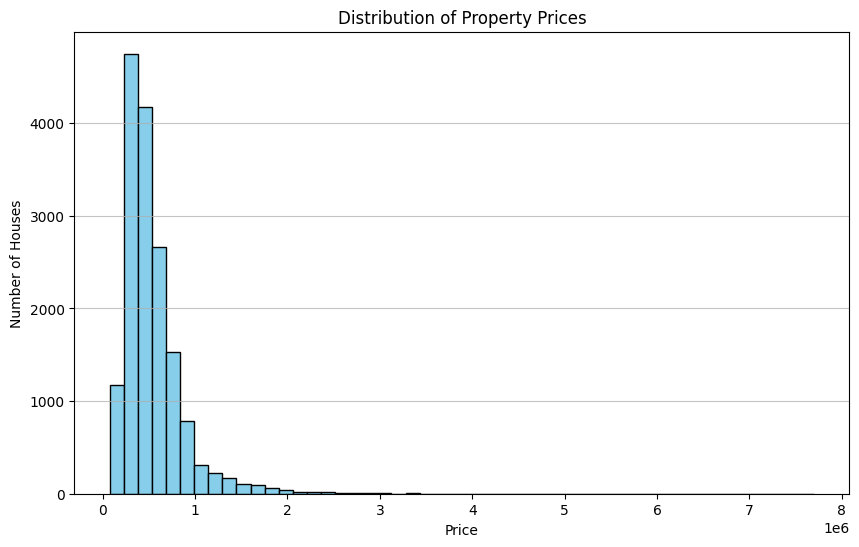

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel("data/train(1).xlsx")

plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Property Prices')
plt.xlabel('Price')
plt.ylabel('Number of Houses')
plt.grid(axis='y', alpha=0.75)

plt.savefig('price_distribution.png', dpi=300)
print("✅ Saved price_distribution.png")